Schedule Preview: 

- **Wed 5/10:** Initial value problems, Euler method, Runge-Kutta
- **Fri 7/10:** Initial value problems, Euler method, Runge-Kutta
- **Mon 10/10:** no class - Thanksgiving
- **Wed 12/10:** Polynomial regression with Ruo Ning Qiu
- **Fri 14/10:** A1, A2 revision class with Ruo Ning Qiu
- **Mon 17/10:** Continue with IVPs, then BVPs, then PDEs

...

- **Fri 28/10: Midterm: syllabus is up to L09** 
   (Make sure you are sitting down in class at 10.00 sharp.)

# MATH 405/607 

# Numerical Methods for Differential Equations

[[Instructor: Christoph Ortner]](http://www.math.ubc.ca/~ortner/)  [[course page]](https://github.com/cortner/math405_2022)

## IVPs Part 1 

* Review of basic ODE theory 
* Euler method
* Improved Euler method
* Truncation error analysis, order of a method
* Runge-Kutta methods 

**References:** 
* https://fncbook.github.io/fnc
* E. Süli and D. Mayer, An Introduction to Numerical Analysis, Ch. 12
* https://people.maths.ox.ac.uk/trefethen/1all.pdf
* E. Hairer and G. Wanner, Solving Ordinary Differential Equations I & II, Springer, 1993 & 1996

For this lecture I'm following https://fncbook.github.io/fnc/ivp/ quite closely as it provides a very nice and intuitive introduction to the numerical solution of IVPs. 

In [1]:
include("math405.jl")

┌ Info: You are not running in the `math405` Jupyter Hub environment. 
│ I'm therefore activating the local environment.
│ Make sure you know what you are doing! If this is unintentional 
│ then get in touch with your instructor to get help.
└ @ Main /Users/ortner/gits/math405_2022/notes/math405.jl:7
  Activating project at `~/gits/math405_2022/notes`


### An Example: SIR Models

$$\begin{aligned} 
 \dot{S}(t) &= -\frac{\beta I S}{N} \\ 
 \dot{I}(t) &= \frac{\beta I S}{N} - \gamma I \\ 
 \dot{R}(t) &= \gamma I 
\end{aligned}$$
* $S(t)$ = number of individual susceptible to a disease
* $I(t)$ = number of infectuous individuals (have been infected and are capable of infecting susceptible individuals)
* $R(t)$ = number of individuals who have recovered or died ($R$ stands for "removed")
* $\beta, \gamma$ are model parameters, $N$ is the total population

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


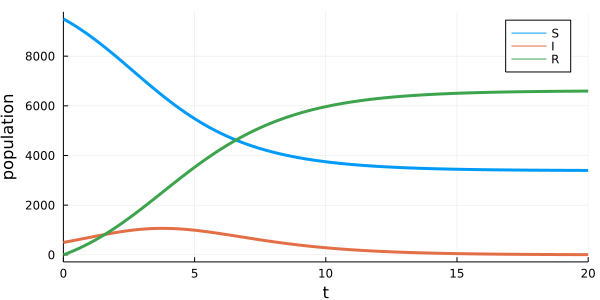

In [2]:
using OrdinaryDiffEq
# u = [S, I, R]
const β = 1.23; const γ = 0.789; const N = 10_000
f(t, u) = [ - β * u[1] * u[2] / N, 
              β * u[1] * u[2] / N - γ * u[2], 
                                    γ * u[2] ]
u0 = [ N * 0.95, N * 0.05, 0.0 ]
prob = ODEProblem((u,p,t) -> f(t, u), u0, (0.0, 20.0))
sol = solve(prob, Tsit5());

plot(sol, vars = 1, lw=3, label = "S", size = (600, 300), ylabel="population")
plot!(sol, vars = 2, lw=3, label = "I")
plot!(sol, vars = 3, lw=3, label = "R")

So what is behind these numerical ODE solver? 
* First review some very basic ODE theory
* Discuss the basic principles on the most elementary scheme, Forward Euler 
* Sketch briefly how to extend to higher-order methods
* Introduce Runge-Kutta methods

Next lectures: qualitative properties of ODE solvers, stability, stiffness, ...

### Review of IVPs

An initial value problem (IVP) is an ODE of the form 

$$ \begin{aligned}
   \dot{u} &= f(t, u(t)), \qquad t \in (0, T], \\ 
     u(0) &= u_0
\end{aligned} $$

where $f : (0, T] \times D \to \mathbb{R}^N$, $D \subset \mathbb{R}^N$, $T > 0$ (possibly infinite) and $u_0 \in \mathbb{R}^N$.

Higher-order problems, such as 
$$ 
    m \ddot{u} + \gamma \dot{u} = f(t, u)
$$
can be rewritten as extended systems in terms of $x = (u, v) = (u, \dot{u})$, 
$$
    \begin{pmatrix} \dot{u} \\ \dot{v} \end{pmatrix}
    = 
    \begin{pmatrix} v \\ m^{-1}(f(t, u) - \gamma v) \end{pmatrix}
$$
**NB: this is not always a good idea; see L11!**

**REMARKS:** 
* Throughout this lecture, if you are uncomfortable with multi-variate calculus in $\mathbb{R}^N$, e.g. jacobi matrix, partial derivatives, norms and inner products, then just take $N = 1, 2, 3$.
* If you are uncomfortable with $\mathbb{R}^N$ because it is "too concrete", then just replace $\mathbb{R}^N$ with a Banach space and everything will still work (sort of, sometimes you want a Hilbert space...)

### Review of IVPs

For simplicity we always assume $f \in C^1([0, \infty) \times \mathbb{R}^N)$ and solve the IVP on $[0, \infty)$

$$ \begin{aligned}
   \dot{u} &= f(t, u(t)), \qquad t > 0 \\ 
     u(0) &= u_0
\end{aligned} $$

**Existence and Uniqueness (simplified):** If $|\partial f / \partial u|$ is bounded, then $\exists! u \in C^1([0, \infty); \mathbb{R}^N)$ solving the IVP.

**Maximal Existence and Blowup:** without boundedness of $|\partial f / \partial u|$
$\exists! T_* \in (0, \infty], u \in C^1([0, T_*); \mathbb{R}^N)$ such that 
* $u$ solves the IVP on $(0, T_*)$; and
* if $T_* < \infty$, then $|u(t)| \to \infty$ as $t \to T_*$.

see Assignment A3!

Blow-up in action: 

* No blow-up, solution exists for $t \to \infty$
$$ 
    \dot{u} = u, u(0) = 1 \qquad \Rightarrow \qquad u(t) = e^t
$$

* Finite-time blow-up: solution cannot be extended past $t = 1$
$$ 
    \dot{u} = u^2, u(0) = 1 \qquad \Rightarrow \qquad u(t) = \frac{1}{1-t}
$$

### An Example: SIR Models

$$\begin{aligned} 
 \dot{S}(t) &= -\frac{\beta I S}{N} \\ 
 \dot{I}(t) &= \frac{\beta I S}{N} - \gamma I \\ 
 \dot{R}(t) &= \gamma I 
\end{aligned}$$
or to bring it into the form $\dot{u} = f(u)$ just write 
$$
    \frac{d}{dt} \begin{pmatrix} S \\ I \\ R \end{pmatrix}
    = 
    \begin{pmatrix}
        - \beta I S / N \\ 
        \beta I S / N - \gamma I \\ 
        \gamma I 
    \end{pmatrix}
$$
i.e. $u = (S, I, R)$ and $f(u) = (- \beta I S / N, \beta I S / N - \gamma I, \gamma I )$


## Towards our first ODE Solver

$$
\dot{u} = f(t, u(t))
$$ 
Many analogues with the intro lecture on BVPs:
* discretise the solution, i.e., we will seek an approximation to $U_n \approx u(t_n)$ at grid points $t_n = h n$.
* as before need to discretise the ODE as well!

If we know $u(t_n)$ then we can approximate $u(t_n+h)$ via Taylor expansion, 
$$ 
    u(t_{n+1})= u(t_n + h) = u(t_n) + h \dot{u}(t_n) + \frac{h^2}{2} \ddot{u}(\tau_n)
$$
But $u$ solves the ODE, so $\dot u = f$, hence 
$$ 
    u(t_{n+1}) = u(t_n) + h f(t_n, u(t_n)) + \frac{h^2}{2} \ddot{u}(\tau_n)
$$
Inserting $U_n \approx u(t_n)$ and dropping the remainder yields .... 

## Forward Euler Method

$$ 
  U_{n+1} = U_n + h f(t_n, U_n)
$$

In [3]:
function euler(f, u0, h, T)
    t = 0.0:h:T 
    U = zeros(length(u0), length(t)); U[:, 1] = u0 
    for n = 2:length(t) 
        U[:,n] = U[:,n-1] + h * f(t[n-1], U[:,n-1])
    end 
    return U, t
end

euler (generic function with 1 method)

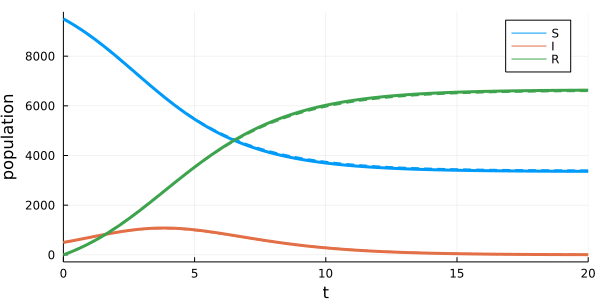

In [10]:
U, tt = euler(f, u0, 0.1, 20.0)   # play with the time-step!!
plot(sol, label = "", size = (600, 300), lw=2, ls = :dash, ylabel="population")
plot!(tt, U[1,:], lw=3, c=1, label = "S", size = (600, 300))
plot!(tt, U[2,:], lw=3, c=2, label = "I")
plot!(tt, U[3,:], lw=3, c=3, label = "R")

In [11]:
println("Number of steps `OrdinaryDiffEq`: ", length(sol.t))
println("Number of steps `euler`: ", size(U, 2))

Number of steps `OrdinaryDiffEq`: 20
Number of steps `euler`: 201


## Error Analysis

Very similar strategy as for the BVP: 

1. take the exact solution and insert it into the numerical scheme $\to$ *truncation error*
$$ \begin{aligned}
  u(t_{n+1}) &= u(t_n) + h f(t_n, u(t_n)) + \frac{h^2}{2} \ddot{u}(\tau_n) \\ 
             &=: u(t_n) + h f(t_n, u(t_n)) + h T_n \\ 
\end{aligned} $$
where $\|T_n\| \leq \frac{1}{2} h \|\ddot{u}\|_\infty$.

2. Subtract the numerical solution $U_{n+1} = U_n + h f(t_n, U_n)$
$$ \begin{aligned}
   u(t_{n+1}) - U_{n+1}  &= u(t_n) - U_n + h [f(t_n, u(t_n)) - f(u_n, U_n)] + h T_n \\ 
   \|u(t_{n+1}) - U_{n+1}\| &\leq \|u(t_n) - U_n\| + h \|f(t_n, u(t_n)) - f(u_n, U_n)\| + h \|T_n\|
\end{aligned} $$

$$ 
   \|u(t_{n+1}) - U_{n+1}\| \leq \|u(t_n) - U_n\| + h \|f(t_n, u(t_n)) - f(t_n, U_n)\| + h \|T_n\|
$$

3. This step is different (and ad hoc): remove the nonlinearity ... Let's assume that $\|\partial_u f\| \leq L$, then $\|f(t_n, u(t_n)) - f(t_n, U_n)\| \leq L \| u(t_n) - U_n \|$ and hence

$$
   \|u(t_{n+1}) - U_{n+1}\| \leq \|u(t_n) - U_n\| + h L \|u(t_n) - U_n\| + h \|T_n\| 
$$


4. Stability: Call $e_n := \|u(t_n) - U_n\|$ and use $\|T_n\| \leq C h$ then we have 
$$ 
    e_{n+1} \leq (1+ h L) e_n + C h^2 
$$
Using $e_0 = 0$ then via induction we obtain
$$ 
    e_n \leq C h \frac{ (1+hL)^n - 1 }{L} \leq C h \frac{e^{L t_n} - 1}{L}.
$$
(this is called a Gronwall inequality; cf. recorded lecture...)

### Summary Error Analysis: 

$$\begin{aligned} 
    \dot{u} &= f(t, u(t)), \qquad u(0) = u_0, \\ 
    U_{n+1} &= U_n + h f(t_n, U_n), \qquad U_0 = u_0
\end{aligned}$$

**Theorem:** Suppose that $\| \partial_u f(t, u)\| \leq L$ for all $t, u$, then 
$$
    \| u(t_n) - U_n \| \leq C_{n,f,u} h
$$
where 
$$ 
    C_{n,f,u} = \frac{\|\ddot{u} \|_\infty (e^{L t_n} - 1)}{2L}
$$

**Remark:** If we want an approximate continuous trajectory, then we can interpolate $(U_n)$, e.g., if we use the piecewise affine interpolant
$$ 
    U(t) = U_n \frac{t - t_{n}}{t_{n+1}-t_n} + U_{n+1} \frac{t_{n+1}-t}{t_{n+1} - t_n}, \qquad t \in [t_n, t_{n+1}],
$$
then we have $\dot U = P_0\big[ f(t, U(t)) \big]$ where $P_0[ f(t) ] = f(t_{n-1})$.

And we get the uniform error estimate $\|U - u \|_\infty \leq C_{f,u} h$. Most numerical ODE solvers come with such an embedded interpolation scheme that allows us to evaluate the approximate trajectory between the integration points. 

### Next Steps

* More advanced integrators, e.g., higher-order (smaller error)
    - Runge-Kutta methods
    - Multi-step methods 
* Qualitative properties of exact vs numerical solutions
    - Dissipative systems
    - stiff problems 
    - Hamiltonian systems
* Automatic choice of step-lengths
    - (a posteriori) error indicators
* Time-stepping for time-depending PDEs

**Julia codes:**

* ODE solvers suite: [OrdinaryDiffEq.jl](https://github.com/SciML/OrdinaryDiffEq.jl)
* Wider ecosystem: [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl)
* Tutorial: https://diffeq.sciml.ai/stable/tutorials/ode_example/
* Choice of solvers: https://diffeq.sciml.ai/stable/solvers/ode_solve/
* An older library based on Matlab's ODE solvers: [ODE.jl](https://github.com/SciML/ODE.jl)

**Other important ODE codes:**

* The [Matlab ODE suite](https://www.mathworks.com/help/pdf_doc/otherdocs/ode_suite.pdf)
* More or less an industry standard: [SUNDIALS](https://computing.llnl.gov/projects/sundials)
* An older industry standard: [ODEPACK](https://computing.llnl.gov/casc/odepack/)
* A [comparison](http://www.stochasticlifestyle.com/comparison-differential-equation-solver-suites-matlab-r-julia-python-c-fortran/) 

## Higher-Order Methods 

$$
    \dot{u}(t) = f(t, u(t))
$$

To derive Euler's method we performed a Taylor expansion 
$$ 
    u(t_n+h) = u(t_n) + h \dot{u}(t_n) + \frac{h^2}{2} \ddot{u}(\tau_n)
$$
and truncated the $O(h^2)$ term.

To get a higher-order method, let's continue the expansion. 
$$ 
    u(t_n+h) = u(t_n) + h \dot{u}(t_n) + \frac{h^2}{2} \ddot{u}(t_n) + O(h^3)
$$
As before, we have $\dot{u}(t_n) = f(t_n, u(t_n))$, but $\ddot{u}$ is a bit trickier: 

$$
\ddot{u}(t) = \frac{d}{dt} \dot{u} = \frac{d}{dt} f(t, u(t))
    = \partial_t f(t, u(t)) + \partial_u f(t, u(t)) \dot{u}(t)
$$
This suggests that we need to evaluate $\partial_t f, \partial_u f$, putting a huge burden on the code. Can we avoid this?

$$ 
    \ddot{u}(t) = \frac{d}{dt} f(t, u(t)) = \frac{f(t+h, u(t+h)) - f(t, u(t))}{h} + O(h)
$$

Remember we started from 
$$ 
    u(t_n+h) = u(t_n) + h \dot{u}(t_n) + \frac{h^2}{2} \ddot{u}(t_n) + O(h^3)
$$
Dropping $O(h^3)$ this suggests the following scheme: 
$$
    U_{n+1} = U_n + h f(t_n, U_n) + \frac{h^2}{2} \frac{f(t_{n+1}, U_{n+1}) - f(t_n, U_n)}{h}
$$

### The Crank-Nicholson Method 

After re-arranging we get 
$$
    U_{n+1} = U_n + h \frac{f(t_n, U_n) + f(t_{n+1}, U_{n+1})}{2}
$$

* This is an *implicit scheme*: one time-step requires solution of a (nonlinear) equation for $U_{n+1}$.
* There are specific problems where implicit schemes are important; we will return to this topic later.


**Remark:** Connection with trapezoidal rule quadrature and therefore with polynomial interpolation:
$$\begin{aligned}
    u(t_{n+1}) &= u(t_n) + \int_{t_n}^{t_{n+1}} \dot{u}(t) \,dt \\ 
    &= u(t_n) + \int_{t_n}^{t_{n+1}} f(t, u(t)) \,dt \\ 
    &\approx u(t_n) + h \frac{ f(t_n, u(t_n)) + f(t_{n+1}, u(t_{n+1})) }{2}
\end{aligned}$$

How can we avoid the nonlinear equation?
$$
    U_{n+1} = U_n + h \frac{f(t_n, U_n) + f(t_{n+1}, U_{n+1})}{2}
$$

* $U_n + h f(t_n, U_n)$ already gives an approximation to $u(t_{n+1})$. 
* If $U_n = u(t_n)$, then $U_n + h f(t_n, U_n) = u(t_{n+1}) + O(h^2)$. 
* With the additional $h$ in front of the average, this becomes $O(h^3)$ which is precisely the order at which we have truncated.

### Improved Euler Method 

$$
    U_{n+1} = U_n + h \frac{f(t_n, U_n) + f\big(t_{n+1}, U_n + h f(t_n, U_n)\big)}{2}
$$

* $O(h^2)$ accuracy (see below) at the cost of 2 function evaluations per step
* We can interpret this as a *Predictor-corrector method* or as a *Runge-Kutta method* -> we look at these next.

In [ ]:
function ieuler(f, u0, h, T)
    t = 0.0:h:T 
    U = zeros(length(u0), length(t)); U[:, 1] = u0 
    for n = 2:length(t) 
        F = f(t[n-1], U[:,n-1])
        U[:,n] = U[:,n-1] + 0.5 * h * (F + f(t[n], U[:,n-1] + h * F))
    end 
    return U, t
end

In [ ]:
Ue, tt = euler(f, u0, 0.5, 20.0)   # play with the time-step!!
Ui, tt = ieuler(f, u0, 0.5, 20.0)   # play with the time-step!!
plot(sol, label = "", size = (600, 300), lw=2, ls = :dash, ylabel = "population")
plot!(tt, Ui[1,:], lw=3, c=1, label = "S"); plot!(tt, Ue[1,:], lw=2, style=:dot, c=1, label = "")
plot!(tt, Ui[2,:], lw=3, c=2, label = "I"); plot!(tt, Ue[2,:], lw=2, style=:dot, c=2, label = "")
plot!(tt, Ui[3,:], lw=3, c=3, label = "R"); plot!(tt, Ue[3,:], lw=2, style=:dot, c=3, label = "")

### Convergence study
...validating the theory and the code 

In [ ]:
get_err(sol, U, tt) = maximum(norm(sol(t) - u) for (t, u) in zip(tt, eachcol(U)))
hh = 0.5.^(-1:5); err_eu = [ ]; err_ieu = [ ]
sol = solve(prob, Tsit5(), abstol = 1e-8, reltol=1e-8);
for h in hh 
    push!(err_eu,  get_err(sol,  euler(f, u0, h, 20.0)...))
    push!(err_ieu, get_err(sol, ieuler(f, u0, h, 20.0)...))
end

In [ ]:
plot(hh, err_eu/N, lw=3, m=:o, ms=6, label="Euler Method", xaxis = :log, yaxis = :log, xlabel = L"h", ylabel = L"\|u - U\|_\infty / N", size = (600, 300), legend = :outertopright) 
plot!(hh, err_ieu/N, lw=3, m=:o, ms=6, label = "Improved Euler M.")
plot!(hh[2:end-1], 0.2*hh[2:end-1], lw=2, c=:black, ls=:dash, label = L"h, h^2")
plot!(hh[2:end-1], 0.01*hh[2:end-1].^2, lw=2, c=:black, ls=:dash, label = "")
plot!(hh[1:end-4], 0.0002*hh[1:end-4].^5, lw=2, c=:lightgrey, ls=:dash, label = L"h^5")

### Error Analysis of (Explicit) Higher-Order Schemes

We can rewrite the improved Euler method much more briefly as

$$\begin{aligned}
    U_{n+1} &=  U_n + h \Phi(t_n, U_n, h) \\ 
    &:= U_n + h \frac{f(t_n, U_n) + f\big(t_{n}+h, U_n + h f(t_n, U_n)\big)}{2}
\end{aligned}$$

In fact all *explicit one-step methods* can be written in this way! 

If we have such a method, then we can ask what the truncation error is. Suppose $u$ solved the ODE, then 

$$ 
   u(t_n + h) = u(t_n) + h \Phi(t_n, u(t_n), h) + h T_n
$$
where 
$$ 
    T_n = \frac{ u(t_n + h) - u(t_n)}{h} - \Phi(t_n, u(t_n), h)
$$
is called the *truncation error* or *local truncation error*. It measures the *additional error* we commit in one time-step.

**Definition:** We say that a numerical integrator is of order $p$ if $|T_n| = O(h^p)$ as $h \to 0$.

**Theorem:** If an integrator $\Phi$ is of order $p$, i.e., $\|T_n\| \leq C h^p$ and if we have the Lipschitz bound $|\partial_u \Phi(t, u, h)| \leq L$ for all $t, u$, then 

$$ 
    \| u(t_n) - U_n \| \leq C_{n,f,u} h^p
$$

where $C_{n,f,u} =  C \frac{e^{L t_n} - 1}{L}$. 

**Proof:** the proof is identical to the one for the basic Euler method; see [here](https://fncbook.github.io/fnc/ivp/euler.html) for a sketch.


# Outlook: Runge-Kutta Methods 

A nice and "tidy" way to implement the improved Euler method, 
$$ 
U_{n+1} =  U_n + h \frac{f(t_n, U_n) + f\big(t_{n}+h, U_n + h f(t_n, U_n)\big)}{2}
$$
is 
```
While t < T
    k1 = h * f(t, U)
    k2 = h * f(t+h, U + k1)
    U = U + 0.5 * k1 + 0.5 * k2 
    t = t + h 
end
```
This is called a 2-stage Runge-Kutta (RK) method.

**Definition:** An $s$-stage explicit RK method is an integrator of the form 

$$\begin{aligned}
    k_1 &= h f(t_n, U_n) \\ 
    k_2 &= h f(t_n + c_2 h, U_n + a_{21} k_1) \\ 
    k_3 &= h f(t_n + c_3 h, U_n + a_{31} k_1 + a_{32} k_2) \\ 
    &\vdots \\ 
    k_{s} &= h f(t_n + c_{s} h, U_n + a_{s,1} k_1 + \dots + a_{s,s-1} k_{s-1}) \\ 
    U_{n+1} &= U_n + b_1 k_1 + b_2 k_2 + \dots + b_s k_s
\end{aligned}$$

The recipe is usually displayed in a [*Butcher table*](https://en.wikipedia.org/wiki/John_C._Butcher), 

$$
\begin{array}{c|ccccc}
    0      &       & & & &  \\
    c_2    & a_{21}   &&& &   \\
    c_3    & a_{31} & a_{32} & & &   \\
    \vdots &   \vdots     &   & \ddots & &  \\
    c_{s}    & a_{s,1} & a_{s,2} & \cdots & a_{s,s-1} &   \\ \hline
           &  b_1 & b_2 & \cdots & b_{s-1} & b_s 
\end{array}
$$

E.g., the improved Euler method is given by 
$$
\begin{array}{c|cc}
    0 &   & \\
    1 & 1 & \\ \hline 
      & 1/2 & 1/2 
\end{array}
$$

The most famous and most common RK method (RK4)
$$ 
\begin{array}{c|cccc}
    0   &      &   &   & \\
    1/2 & 1/2  &   &   & \\
    1/2 &   0  & 1/2 & & \\
    1   &   0  & 0 & 1 & \\ \hline 
        & 1/6 & 1/3 & 1/3 & 1/6 
\end{array}
$$
Notice the many zeros!

And just for fun ... Fehlberg, 13-stage, order-8 method:
$$
\begin{split}\renewcommand{\arraystretch}{1.5}
\begin{array}{r|ccccccccccccc}
  0&   0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0\\
  \frac{2}{27}&   \frac{2}{27}& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0\\
  \frac{1}{9}&   \frac{1}{36}& \frac{1}{12}& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0\\
  \frac{1}{6}&   \frac{1}{24}& 0& \frac{1}{8}& 0& 0& 0& 0& 0& 0& 0& 0& 0& 0\\
  \frac{5}{12}&   \frac{5}{12}& 0& -\frac{25}{16}& \frac{25}{16}& 0& 0& 0& 0& 0& 0& 0& 0& 0\\
  \frac{1}{2}&   \frac{1}{20}& 0& 0& \frac{1}{4}& \frac{1}{5}& 0& 0& 0& 0& 0& 0& 0& 0\\
  \frac{5}{6}&   -\frac{25}{108}& 0& 0& \frac{125}{108}& -\frac{65}{27}& \frac{125}{54}& 0& 0& 0& 0& 0& 0& 0\\
  \frac{1}{6}&   \frac{31}{300}& 0& 0& 0& \frac{61}{225}& -\frac{2}{9}& \frac{13}{900}& 0& 0& 0& 0& 0& 0\\
  \frac{2}{3}&   2& 0& 0& -\frac{53}{6}& \frac{704}{45}& -\frac{107}{9}& \frac{67}{90}& 3& 0& 0& 0& 0& 0\\
  \frac{1}{3}&   -\frac{91}{108}& 0& 0& \frac{23}{108}& -\frac{976}{135}& \frac{311}{54}& -\frac{19}{60}& \frac{17}{6}& -\frac{1}{12}& 0& 0& 0& 0\\
  1&   \frac{2383}{4100}& 0& 0& -\frac{341}{164}& \frac{4496}{1025}& -\frac{301}{82}& \frac{2133}{4100}& \frac{45}{82}& \frac{45}{164}& \frac{18}{41}& 0& 0& 0\\
  0&   \frac{3}{205}& 0& 0& 0& 0& -\frac{6}{41}& -\frac{3}{205}& -\frac{3}{41}& \frac{3}{41}& \frac{6}{41}& 0& 0& 0\\
  1&   -\frac{1777}{4100}& 0& 0& -\frac{341}{164}& \frac{4496}{1025}& -\frac{289}{82}& \frac{2193}{4100}& \frac{51}{82}& \frac{33}{164}& \frac{12}{41}& 0& 1& 0\\
  \hline
  & 0& 0& 0& 0& 0& \frac{34}{105}& \frac{9}{35}& \frac{9}{35}& \frac{9}{280}& \frac{9}{280}& 0& \frac{41}{840}& \frac{41}{840}
\end{array}\end{split}
$$
<!-- %   \\
%   7& \frac{41}{840}& 0& 0& 0& 0& \frac{34}{105}& \frac{9}{35}& \frac{9}{35}& \frac{9}{280}& \frac{9}{280}& \frac{41}{840}& 0& 0
 -->


### Existence of explicit RK formulas

see [Trefethen (1994)](https://people.maths.ox.ac.uk/trefethen/1all.pdf) or Butcher (1987)

![trefthm](existence_rk.png)